# Deconvolution Benchmark: Julia

---
## Setup

In [1]:
using DeconvOptim, TestImages, Colors, ImageIO, Noise, ImageShow, Images, Plots, BenchmarkTools, FFTW

In [2]:
# FFTW.set_provider!("mkl")
FFTW.get_provider()

"mkl"

In [3]:
FFTW.set_num_threads(8)

---
## Test Image

Una vez importados los paquetes lo que hemos hecho ha sido coger una imagen de prueba, añadirla borrosidad y ruido y hacer la deconvolución en 2D sin regularizar.
Usaremos la misma PSF para el código en python y el mismo número de iteraciones.


In [4]:
# Cargar la imagen de prueba
img = load("ImagenPrueba.jpg")
img = Float32.(img)

# Generar la PSF (Point Spread Function)
psf = Float32.(generate_psf(size(img), 30))

# Crear una versión borrosa y ruidosa de la imagen
img_b = conv(img, psf)  # Imagen borrosa
img_n = poisson(img_b, 300)  # Imagen borrosa y ruidosa

# Guardar la imagen borrosa y ruidosa
# save("blurrednoisy_img.jpg", img_b)

# Deconvolución 2D sin regularizador
res_no_reg, o = deconvolution(img_n, psf, regularizer=nothing, iterations=30)

# Medir el tiempo de ejecución de la deconvolución

b = @benchmark  deconvolution(img_n, psf, regularizer=nothing, iterations=30) samples=15 evals=1

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  368.112 ms … 664.680 ms  ┊ GC (min … max):  2.35% … 44.57%
 Time  (median):     430.242 ms               ┊ GC (median):    14.65%
 Time  (mean ± σ):   506.135 ms ± 133.465 ms  ┊ GC (mean ± σ):  27.78% ± 17.95%

  █ ██    █   █                                      █    █  ██  
  █▁██▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁██ ▁
  368 ms           Histogram: frequency by time          665 ms <

 Memory estimate: 172.58 MiB, allocs estimate: 5827.

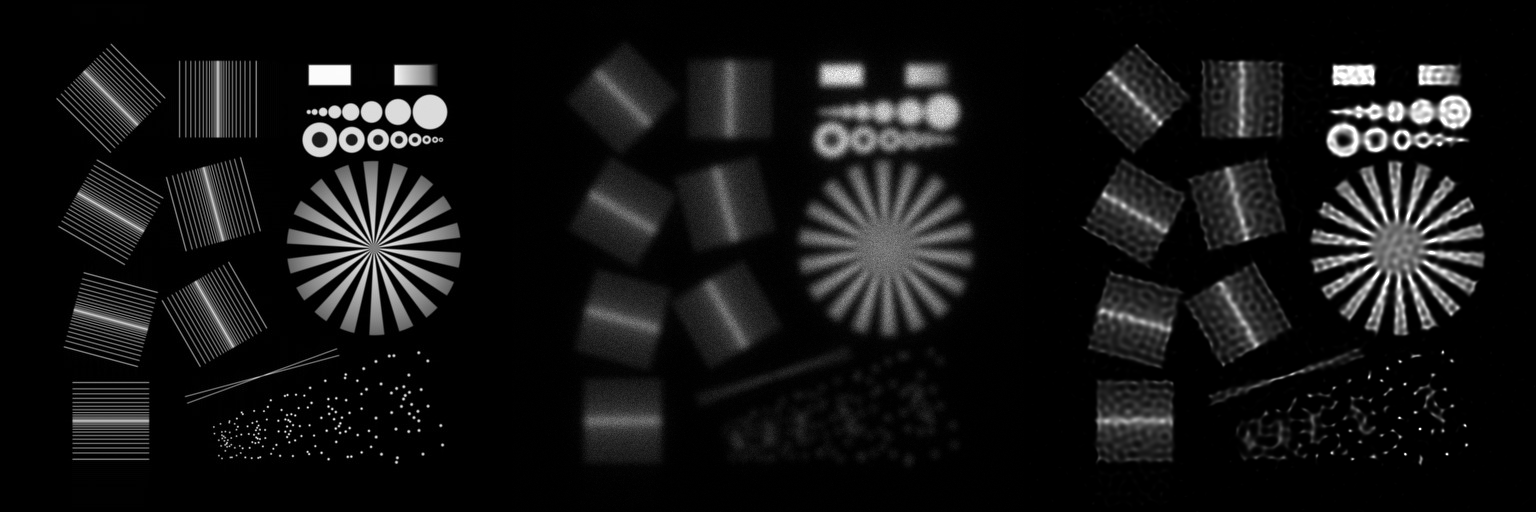

In [5]:
# Mostrar los resultados finales junto a la versión original y la versión borrosa
Gray.([img img_n res_no_reg])

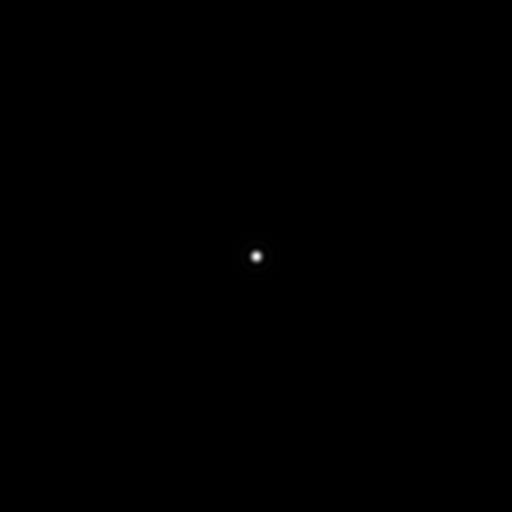

In [6]:
# Suponemos que psf ya está definida
# Normaliza los valores de la PSF al rango [0, 1]
psf_min = minimum(psf)
psf_max = maximum(psf)
psf_normalized = (psf .- psf_min) ./ (psf_max - psf_min)
psf_gray = Gray.(psf_normalized)  # Convertir a escala de grises

# Centrar la PSF utilizando ifftshift
centered_psf = ifftshift(psf_normalized)
centered_psf_gray = Gray.(centered_psf)  # Convertir a escala de grises

# Guardar la PSF normalizada como una imagen JPEG
# save("psf.jpg", centered_psf_gray)

# Mostrar la PSF centrada
display(centered_psf_gray)


Ahora vamos a usar la función richardson_lucy_iterative del módulo deconvoptim.jl sin regularización.

In [7]:
# Deconvolución iterativa de Richardson-Lucy sin regularizador
restored_img = richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30);

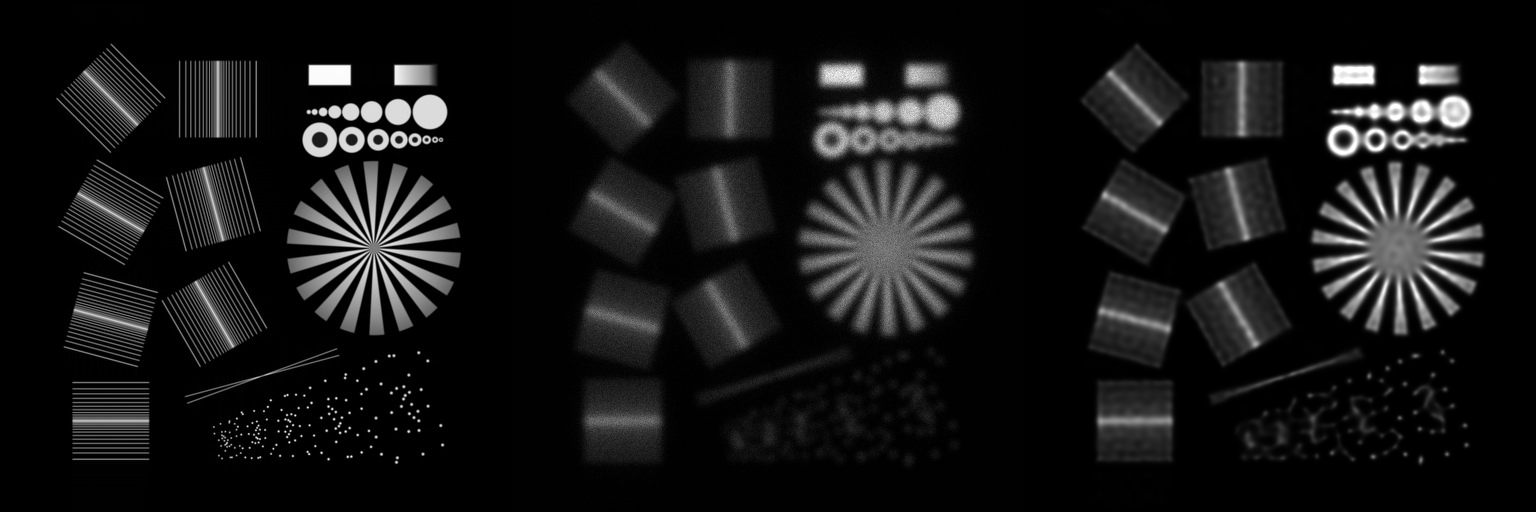

In [8]:
Gray.([img img_n restored_img])

In [9]:
c = @benchmark richardson_lucy_iterative(img_n, psf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  27.672 ms … 43.026 ms  ┊ GC (min … max): 0.00% … 24.24%
 Time  (median):     31.174 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   31.722 ms ±  2.518 ms  ┊ GC (mean ± σ):  2.07% ±  4.70%

         ▁▃   ▁▃▁▄▄▁▁▁█ ▁           ▁                          
  ▄▁▁▆▄▄▆██▆▇▄█████████▇█▆▄▆▁▄▄▁▆▄▁▁█▁▄▄▆▇▁▁▁▁▄▁▁▁▁▁▄▁▁▁▁▁▄▁▄ ▄
  27.7 ms         Histogram: frequency by time        39.4 ms <

 Memory estimate: 7.01 MiB, allocs estimate: 33.

Veremos ahora ejemplos con TV regularization en Julia

In [10]:
# Deconvolución iterativa de Richardson-Lucy con regularizador
optim_res = richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30)
d1 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=TV(), iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 63 samples with 1 evaluation.
 Range (min … max):  821.069 ms …   1.086 s  ┊ GC (min … max): 2.28% … 1.87%
 Time  (median):     941.999 ms              ┊ GC (median):    1.79%
 Time  (mean ± σ):   941.820 ms ± 56.245 ms  ┊ GC (mean ± σ):  2.18% ± 1.17%

                           ▅  ▂   ▂▂ ▂    █                     
  ▅▁▅▁▁▁█▁▅▁▅▅▅▁▅▁▅▅▅██▅████▁▁██▅███▁█▁▅▅██▁█▁▅▁▅▅▁▁▅▁▁▁▁▅▁▁▁█ ▁
  821 ms          Histogram: frequency by time          1.06 s <

 Memory estimate: 76.77 MiB, allocs estimate: 640301.

In [11]:
# Deconvolución iterativa de Richardson-Lucy con regularizador (optimizada)
tv = TV()

#628 (generic function with 1 method)

In [12]:
d2 = @benchmark richardson_lucy_iterative(img_n, psf, λ=0.05, regularizer=tv, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  65.347 ms … 134.158 ms  ┊ GC (min … max): 0.00% … 3.30%
 Time  (median):     81.400 ms               ┊ GC (median):    4.73%
 Time  (mean ± σ):   81.351 ms ±   7.114 ms  ┊ GC (mean ± σ):  3.40% ± 2.73%

                               ▁ ▄▁ ▃█▃▄▁▃ ▄                    
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▄▄▄▆▄▆▆▇▄▄▇▆▄▄▇▁█▄██▁██████▇█▄▄▄▆▄▇▁▄▆▆▁▁▁▁▁▁▄▄ ▄
  65.3 ms         Histogram: frequency by time         92.6 ms <

 Memory estimate: 38.04 MiB, allocs estimate: 1057.

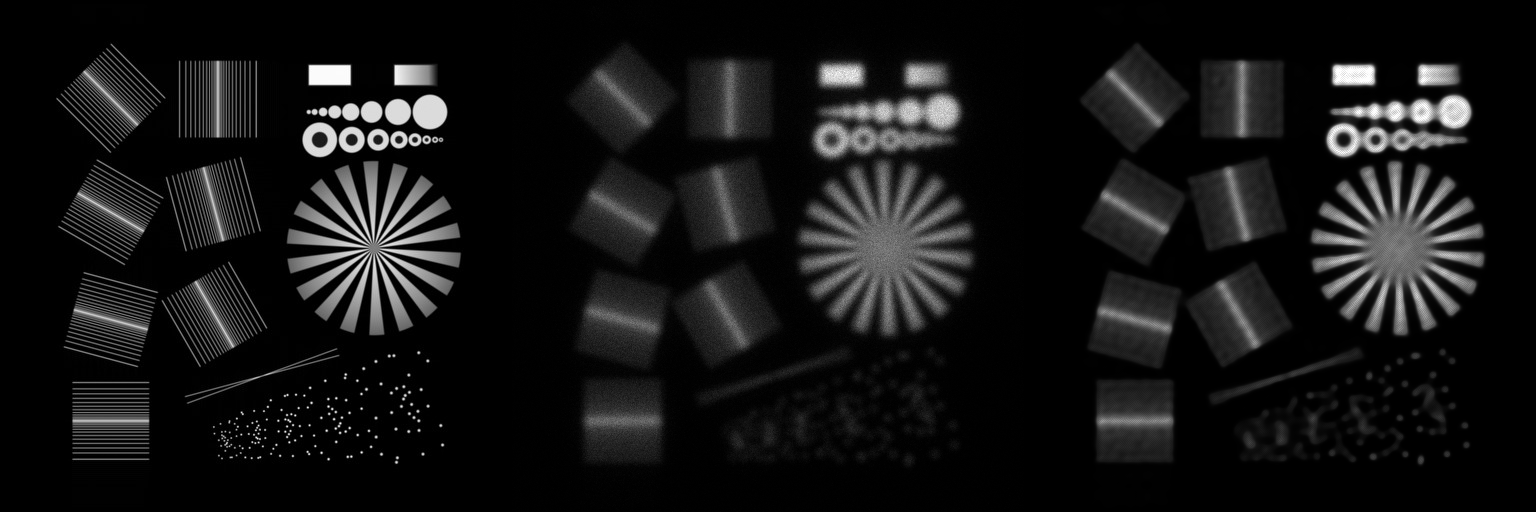

In [13]:
Gray.([img img_n optim_res])

---
## Cell
Test usando solo el plano central del `cells3D` dataset

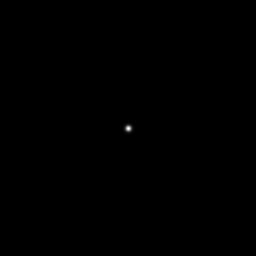

In [14]:
img = load("cells2d_convolved.tif")
img = Float32.(img)

psf = load("cells2d_psf.tif")
psf = Float32.(psf);

Gray.(psf/maximum(psf))

In [15]:
ipsf = ifftshift(psf);

In [16]:
deconvolved = richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30);

In [17]:
 c = @benchmark richardson_lucy_iterative(img, ipsf; regularizer=nothing, iterations=30) samples=100 evals=1 seconds=60

BenchmarkTools.Trial: 100 samples with 1 evaluation.
 Range (min … max):  7.467 ms … 23.292 ms  ┊ GC (min … max): 0.00% … 57.11%
 Time  (median):     8.825 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.036 ms ±  2.098 ms  ┊ GC (mean ± σ):  2.98% ±  8.19%

      ▄█▂                                                     
  ▄▆▄▅███▃▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂ ▂
  7.47 ms        Histogram: frequency by time          23 ms <

 Memory estimate: 1.76 MiB, allocs estimate: 33.

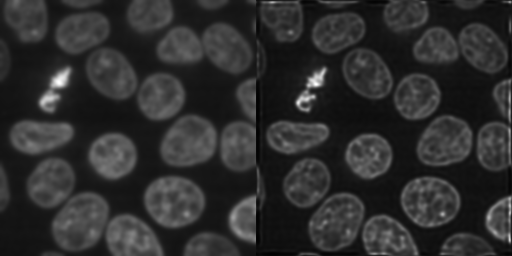

In [18]:
Gray.([img/maximum(img) deconvolved/maximum(deconvolved)])